# PSF Extractor
---

#### Overview
PSF extractor walkthrough

#### Libraries

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Log settings

In [2]:
import logging
logging.getLogger().setLevel(logging.INFO)

#### Get that spicy colormap

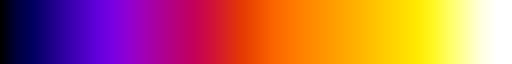

In [3]:
from psf_extractor.util import get_Daans_special_cmap
fire = get_Daans_special_cmap()
fire

## 1) Find features
---
First step of workflow is to find features within a 3D image stack. Features are found using `trackpy.locate`, which takes the expected feature diameters and a minimum mass as input. The expected feature diameters are in pixel dimensions, and ought to be rounded up to the nearest odd integer. The minimum mass is the minimum "integrated brightness" which is used as a parameter to filter out spurious features.

In [4]:
import trackpy
from skimage import exposure
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from psf_extractor import get_stack

### Set parameters
Trackpy takes expected feature diameters in (x, y, z) as input. Requires input diameters to be odd and recommends rounding up.

In [5]:
# Set pixel sizes [nm/px]
psx = 64
psy = psx
psz = 125

# Set expected feature diameters [nm]
dx_nm = 800
dy_nm = dx_nm
dz_nm = 1500

# Convert expected feature diameters [nm --> px]
# and round up to nearest odd integer
dx = dx_nm / psx
dy = dy_nm / psy
dz = dz_nm / psz

# Round diameters up to nearest odd integer
diameters = np.ceil([dz, dy, dx]).astype(int) // 2 * 2 + 1
diameters

array([13, 13, 13])

In [6]:
# Set candidate minimum masses
min_masses = [50, 100, 500, 1000, 2000, 5000]

### Create stack

In [7]:
# Set directory of image stack
file_pattern = '../data/sample_zstack_png_sequence/'
# Load image stack
stack = get_stack(file_pattern)

INFO:root:Creating stack from directory.
INFO:root:Reading image file (1/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0017.png
INFO:root:Reading image file (2/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0003.png
INFO:root:Reading image file (3/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0002.png
INFO:root:Reading image file (4/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0016.png
INFO:root:Reading image file (5/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0028.png
INFO:root:Reading image file (6/32) : ../data/sample_zstack_png_sequence/20201130_162150_collar_0.146_yaw_1.62deg_cyls_corr_back_foc_325.3um_15deg0000.png
INFO:root:Reading image file 

### Calculate maximum intensity projection in `z`

In [8]:
# Calculate the maximum projection image
mip = np.max(stack, axis=0)

# Normalize the maximum intensity projection
mipn = exposure.rescale_intensity(mip)
mipn *= 255./mipn.max()

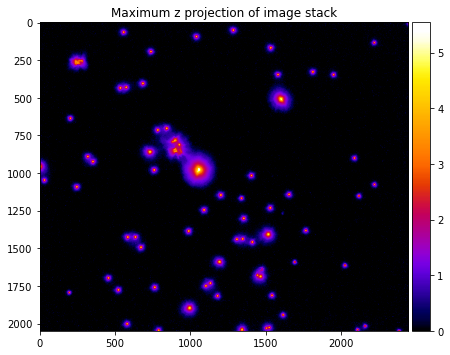

In [9]:
# Create figure
fig, ax = plt.subplots(figsize=(7, 7))
# Take log to enhance contrast, avoid /b0 error
mpn_log = np.log(mipn,
                 out=np.zeros_like(mipn),
                 where=mipn!=0)
im = ax.imshow(mpn_log, cmap=fire)
ax.set_title('Maximum z projection of image stack')
# Colorbar
div = make_axes_locatable(ax)
cax = div.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax);

### Find features
The appropriate minimum will vary from dataset to dataset. Here a number of minimum masses are experimented with so that the user can select the value they find appropriate.

  0%|          | 0/6 [00:00<?, ?it/s]

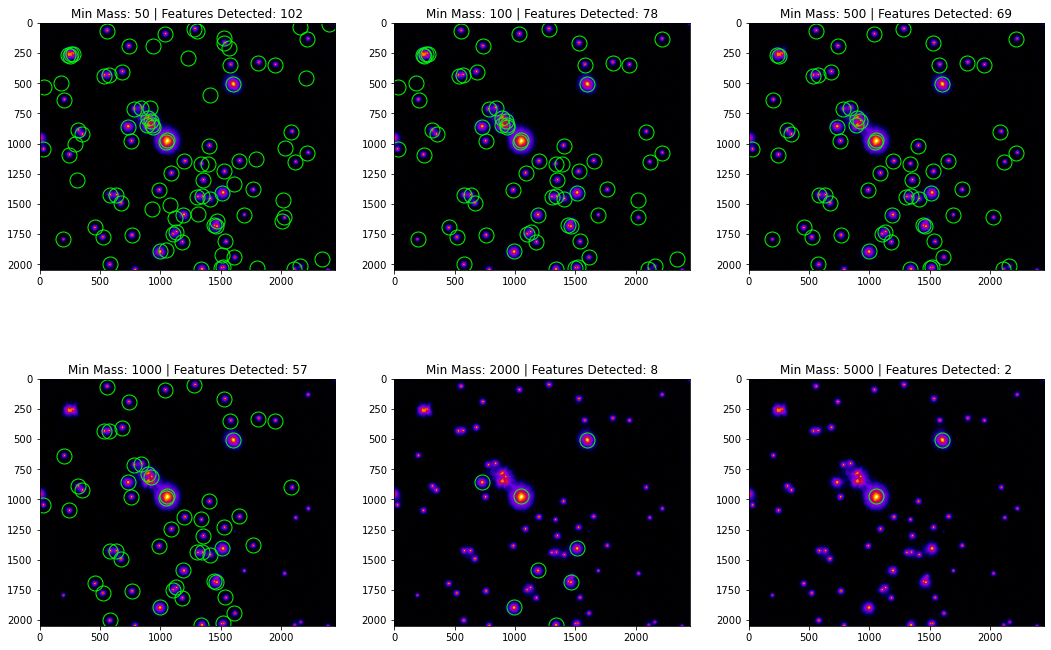

In [10]:
# Set up figure
ncols = 3
nrows = int(np.ceil(len(min_masses) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))

# Loop through candidate minimum masses
for i, min_mass in tqdm(enumerate(min_masses),
                        total=len(min_masses)):

    # Locate features
    df_features = trackpy.locate(mipn,
                                 diameter=diameters[1:],  # (y, x) only
                                 minmass=min_mass).reset_index(drop=True)

    # Plot max projection image
    ax = axes.flat[i]
    # Take log to enhance contrast (avoiding /b0 error)
    mpn_log = np.log(mipn,
                     out=np.zeros_like(mipn),
                     where=mipn!=0)
    ax.imshow(mpn_log, cmap=fire)
    # Plot detected features
    ax.plot(df_features['x'], df_features['y'], ls='', color='#00ff00',
            marker='o', ms=15, mfc='none', mew=1)
    title = f'Min Mass: {min_mass} | Features Detected: {len(df_features):.0f}'
    ax.set_title(title)

#### Find features with chosen minimum mass

In [11]:
# Update value
min_mass = 750

# Locate features
df_features = trackpy.locate(mipn,
                             diameter=diameters[1:],
                             minmass=min_mass).reset_index(drop=True)
# Display a sample of located features
df_features.head()

,y,x,mass,size,ecc,signal,raw_mass,ep
0,53.262390,1282.117447,1665.265887,2.418039,0.049362,70.092658,4426.0,0.005575
1,66.516080,555.069618,1493.991086,2.456970,0.048752,61.048444,3979.0,0.006221
2,95.478668,1037.309400,1629.654295,2.468251,0.060441,66.135814,4287.0,0.005761
3,136.548734,2216.655063,893.116124,2.419070,0.060467,38.437909,2540.0,0.009929
4,170.191908,1530.268528,1578.780592,2.416230,0.061555,67.266341,4284.0,0.005765


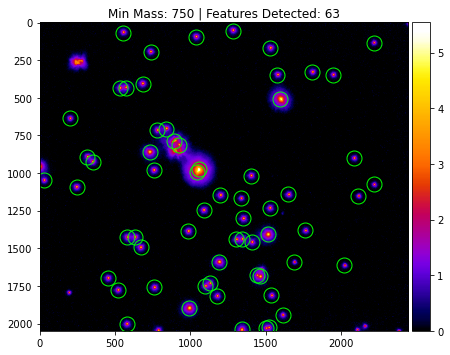

In [12]:
# Create figure
fig, ax = plt.subplots(figsize=(7, 7))
# Take log to enhance contrast (avoiding /b0 error)
mpn_log = np.log(mipn,
                 out=np.zeros_like(mipn),
                 where=mipn!=0)
im = ax.imshow(mpn_log, cmap=fire)
# Plot detected features
ax.plot(df_features['x'], df_features['y'], ls='', color='#00ff00',
        marker='o', ms=15, mfc='none', mew=1)
title = f'Min Mass: {min_mass} | Features Detected: {len(df_features):.0f}'
ax.set_title(title)
# Colorbar
div = make_axes_locatable(ax)
cax = div.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax);

### Filter features based on position

To calculate the PSF, a subvolume is created for each feature. Features with overlapping subvolumes ought to be filtered out. As features are located based on the maximum z projection, this is treated as a 2D problem.

In [13]:
from itertools import combinations
from psf_extractor import bboxes_overlap

In [14]:
# Set bounding box dimensions [μm]
dx_nm = 5
dy_nm = dx_nm

# Convert bounding box dimensions [μm --> px]
dx = dx_nm / psx * 1e3
dy = dy_nm / psy * 1e3

In [15]:
# Create bounding box for each feature based 
# on the dimensions of the subvolume
df_bboxes = df_features.loc[:, ['x', 'y']]

df_bboxes['x_min'] = df_features['x'] - dx/2
df_bboxes['y_min'] = df_features['y'] - dy/2
df_bboxes['x_max'] = df_features['x'] + dx/2
df_bboxes['y_max'] = df_features['y'] + dy/2

df_bboxes.head()

,x,y,x_min,y_min,x_max,y_max
0,1282.117447,53.262390,1243.054947,14.199890,1321.179947,92.324890
1,555.069618,66.516080,516.007118,27.453580,594.132118,105.578580
2,1037.309400,95.478668,998.246900,56.416168,1076.371900,134.541168
3,2216.655063,136.548734,2177.592563,97.486234,2255.717563,175.611234
4,1530.268528,170.191908,1491.206028,131.129408,1569.331028,209.254408


In [16]:
# Collect overlapping features
overlapping_features = []
# Iterate through every (unique) pair of bounding boxes
ij = list(combinations(df_bboxes.index, 2))
for i, j in tqdm(ij, total=len(ij)):

    # Create bounding boxes for each pair of features
    bbox_i = df_bboxes.loc[i, ['x_min', 'y_min', 'x_max', 'y_max']].values
    bbox_j = df_bboxes.loc[j, ['x_min', 'y_min', 'x_max', 'y_max']].values

    # Check for overlap
    if bboxes_overlap(bbox_i, bbox_j):
        overlapping_features.append(i)
        overlapping_features.append(j)

# Remaining features
df_features = df_features.drop(index=overlapping_features)\
                         .reset_index(drop=True)
df_features.head()

  0%|          | 0/1953 [00:00<?, ?it/s]

,y,x,mass,size,ecc,signal,raw_mass,ep
0,53.262390,1282.117447,1665.265887,2.418039,0.049362,70.092658,4426.0,0.005575
1,66.516080,555.069618,1493.991086,2.456970,0.048752,61.048444,3979.0,0.006221
2,95.478668,1037.309400,1629.654295,2.468251,0.060441,66.135814,4287.0,0.005761
3,136.548734,2216.655063,893.116124,2.419070,0.060467,38.437909,2540.0,0.009929
4,170.191908,1530.268528,1578.780592,2.416230,0.061555,67.266341,4284.0,0.005765


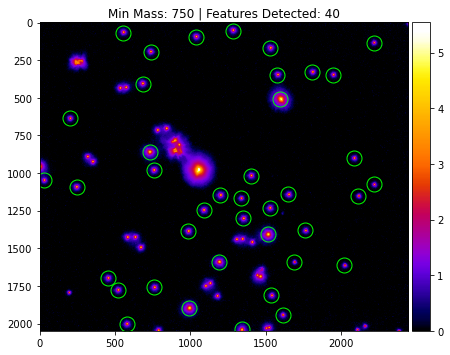

In [17]:
# Create figure
fig, ax = plt.subplots(figsize=(7, 7))
# Take log to enhance contrast, avoid /b0 error
mpn_log = np.log(mipn,
                 out=np.zeros_like(mipn),
                 where=mipn!=0)
im = ax.imshow(mpn_log, cmap=fire)
# Plot detected features
ax.plot(df_features['x'], df_features['y'], ls='', color='#00ff00',
        marker='o', ms=15, mfc='none', mew=1)
title = f'Min Mass: {min_mass} | Features Detected: {len(df_features):.0f}'
ax.set_title(title)
# Colorbar
div = make_axes_locatable(ax)
cax = div.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax);

### Filter based on mass

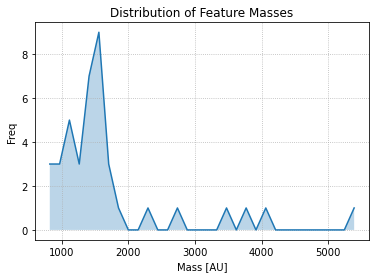

In [18]:
hist, bins = np.histogram(df_features['mass'], bins=32)
bins = (bins[1:] + bins[:-1]) / 2

fig, ax = plt.subplots()
ax.plot(bins, hist)
ax.fill_between(bins, 0, hist, alpha=0.3)
ax.grid(ls=':')
ax.set_xlabel('Mass [AU]')
ax.set_ylabel('Freq')
ax.set_title('Distribution of Feature Masses');

In [19]:
# Not sure what's going on here

In [20]:
#     #Select on mass
#     lenmass = len(features_filt)
#     if lenmass > 12: lenmass /= 2
#     features_filt = features_filt.sort_values('mass').head(n=int(lenmass)).reset_index()

## Fitting
---

### Crop to subvolumes

In [21]:
from psf_extractor import create_substacks

In [22]:
# Set dimensions of subvolume [μm]
wx_nm = 5
wy_nm = wx_nm
wz_nm = 5

# Convert dimensions of subvolume [μm --> px]
wx = wx_nm / psx * 1e3
wy = wy_nm / psy * 1e3
wz = wz_nm / psz * 1e3

# Compile dimensions (z, y, x)
volume = [wz, wy, wx]
volume

[40.0, 78.125, 78.125]

In [34]:
substacks, df_features_ = create_substacks(stack, df_features, volume)

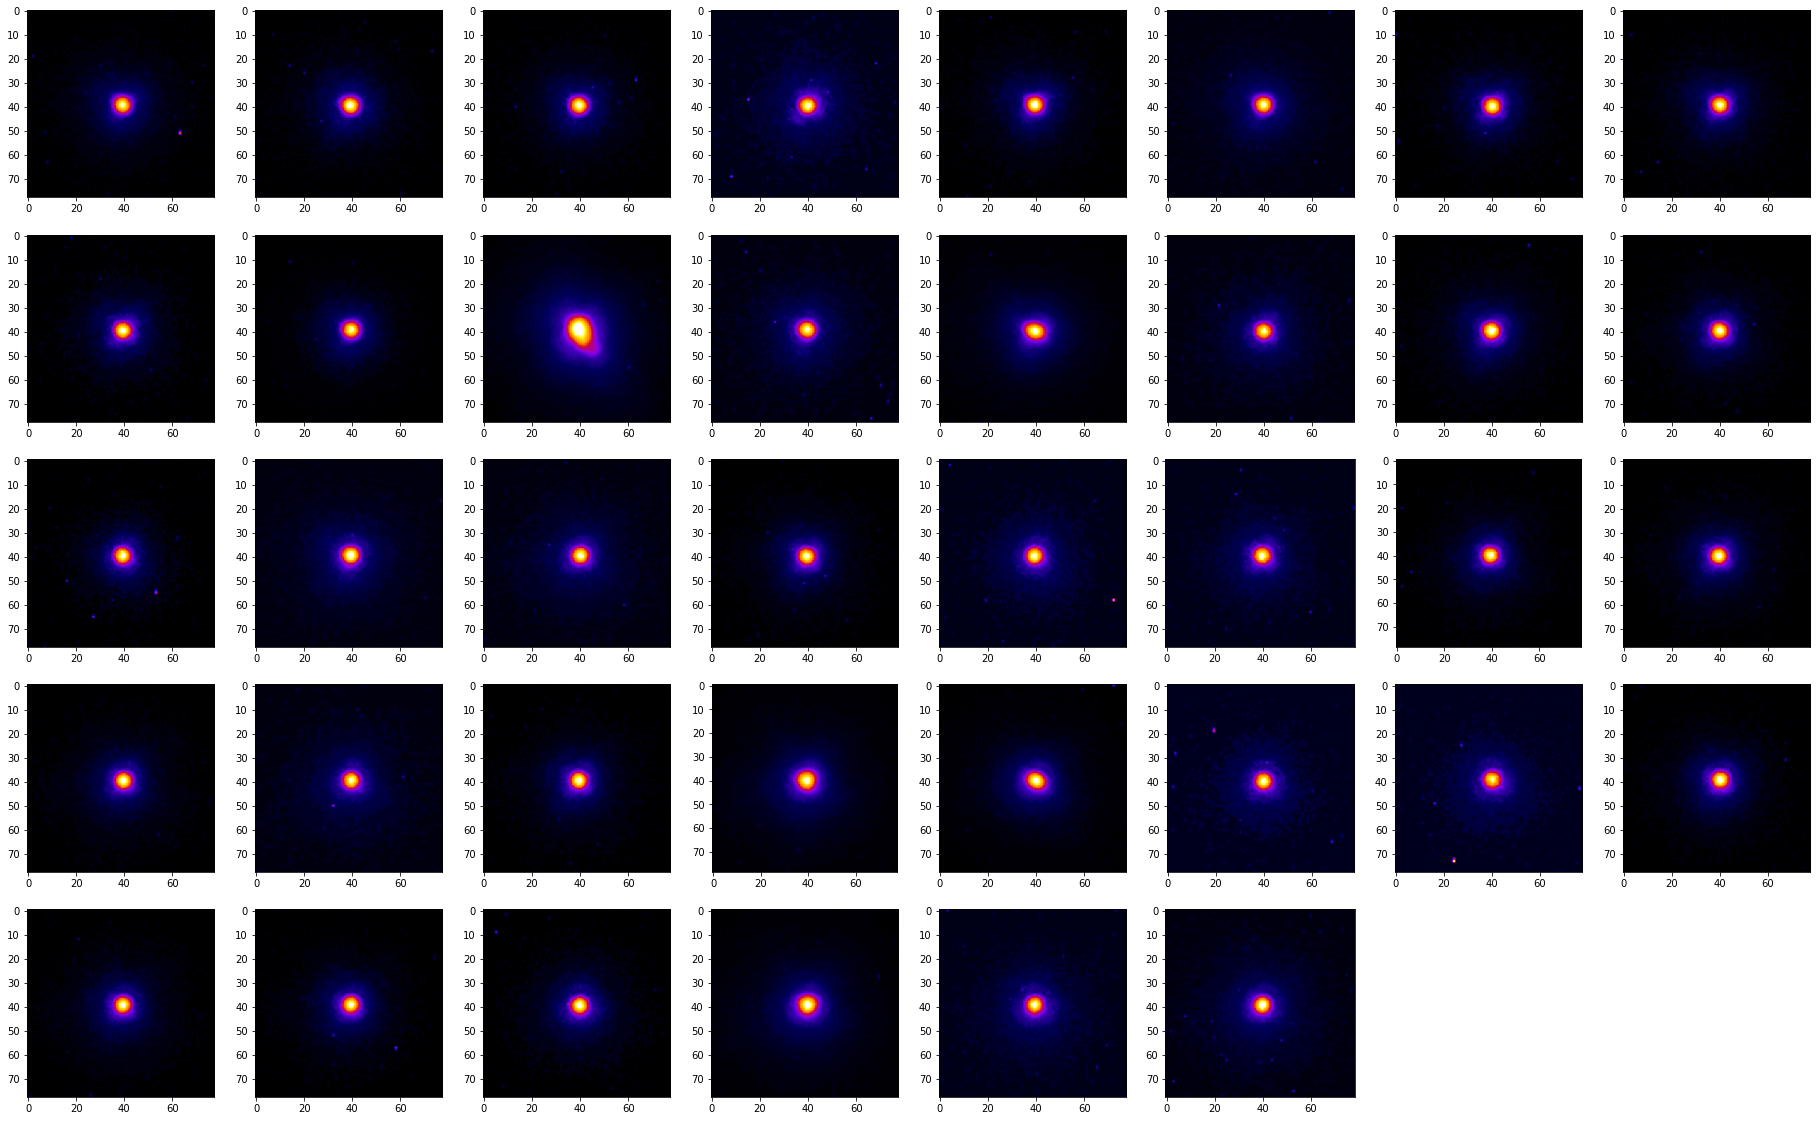

In [35]:
ncols = 8
nrows = int(np.ceil(len(substacks) / ncols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))
for i, substack in enumerate(substacks):
    ax = axes.flat[i]
    mip = np.max(substack, axis=0)
    ax.imshow(mip, cmap=fire)
# Remove empty subplots
[fig.delaxes(axes.flat[-i-1]) for i in range(ncols*nrows - len(substacks))];

### Fit Gaussian
* Do 2D Gaussian fit on maximum intensity projection (along $z$)
* Do 1D Gaussian fit on profile/slice through center
  * Might it be better to sum/integrate in x, y?

In [36]:
from scipy.optimize import curve_fit

from psf_extractor import gaussian_2D, fit_gaussian_2D

In [37]:
columns = ['x0', 'y0', 'sigma_x', 'sigma_y', 'A', 'B']
df_ = pd.DataFrame(columns=columns)

for i, substack in enumerate(substacks):

    # Take maximum intensity projection
    mip = np.max(substack, axis=0)

    # Least squares fit
    popt = fit_gaussian_2D(mip)

    # 
    df_.loc[i, columns] = popt

df_.head()

,x0,y0,sigma_x,sigma_y,A,B
0,39.115625,39.274542,2.592068,2.573765,0.431048,0.007598
1,39.058167,39.522501,2.649941,2.55392,0.383863,0.007149
2,39.325314,39.489727,2.618339,2.539868,0.419847,0.007329
3,39.714924,39.540604,2.69319,2.597114,0.236508,0.005859
4,39.282169,39.211872,2.650698,2.591796,0.408648,0.007567


### Filter based on similarity
Use the Pearson correlation coefficient to filter out oultier PSFs. Each substack is compared to every other substack. Outlier criteria is based on a substack having a PCC that frequently falls outside the acceptable range ($\mu_{PCC} \,\pm\, 3\sigma_{PCC}$).

Why isn't once enough? Because it takes 2 substacks to generate a wild PCC value. One of these substacks may be totally fine, but the only way to tell the "good" substack from the outlier is by checking the number of occurences each substack falls in the outlier range.

How many times is frequently? A bit arbitrary, but $3\times$ the average number of occurences seems to work empirically.

In [38]:
from itertools import combinations
from scipy.stats import pearsonr
from skimage.transform import resize

In [39]:
# Collect PCCs
pccs = []
# Iterate through every (unique) pair of substacks
ij = list(combinations(range(len(substacks)), 2))
for i, j in tqdm(ij, total=len(ij)):

    # Get pairs of substacks
    mip_i = np.max(substacks[i], axis=0)
    mip_j = np.max(substacks[j], axis=0)
    # Enforce same shape (small chance that some substacks
    # have different shape due to round off errors)
    mip_j = resize(mip_j, mip_i.shape)
    # Calculate PCC of maximum intensity projections
    pcc, _ = pearsonr(mip_i.ravel(),
                      mip_j.ravel())
    pccs.append(pcc)

# Convert to array
pccs = np.array(pccs)

  0%|          | 0/703 [00:00<?, ?it/s]

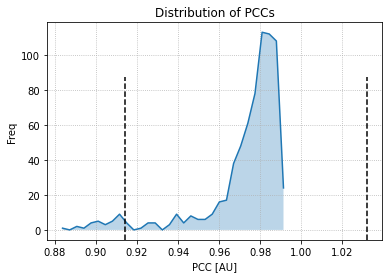

In [40]:
# Get distribution
hist, bins = np.histogram(pccs, bins=32)
bins = (bins[1:] + bins[:-1]) / 2

# Outlier criteria
pcc_min = pccs.mean() - 3*pccs.std()
pcc_max = pccs.mean() + 3*pccs.std()

# Plot distribution
fig, ax = plt.subplots()
ax.plot(bins, hist)
ax.fill_between(bins, 0, hist, alpha=0.3)
# Plot outlier range
ax.axvline(pcc_min, ymax=0.75, color='k', ls='--')
ax.axvline(pcc_max, ymax=0.75, color='k', ls='--')
# Aesthetics
ax.grid(ls=':')
ax.set_xlabel('PCC [AU]')
ax.set_ylabel('Freq')
ax.set_title('Distribution of PCCs');

In [41]:
# Get indices of candidate outliers
suspects_i = np.argwhere((pccs < pcc_min) |\
                         (pccs > pcc_max))
# Convert to indices of substack pairs
suspects_ij = np.array(ij)[suspects_i[:, 0]]

# Determine frequency of out lying (?)
i, counts = np.unique(suspects_ij, return_counts=True)
outliers = i[counts > 3*counts.mean()]
outliers

array([10])

In [43]:
# Remove outliers
df_features_ = df_features_.drop(outliers)
df_features_.head()

,y,x,mass,size,ecc,signal,raw_mass,ep
0,53.262390,1282.117447,1665.265887,2.418039,0.049362,70.092658,4426.0,0.005575
1,66.516080,555.069618,1493.991086,2.456970,0.048752,61.048444,3979.0,0.006221
2,95.478668,1037.309400,1629.654295,2.468251,0.060441,66.135814,4287.0,0.005761
3,136.548734,2216.655063,893.116124,2.419070,0.060467,38.437909,2540.0,0.009929
4,170.191908,1530.268528,1578.780592,2.416230,0.061555,67.266341,4284.0,0.005765


### Upsample and average PSFs

In [33]:
# First, no upsampling

In [57]:
# Collect volumes for PSF
psf_volumes = []
for i, row in df_features_.iterrows():
    psf_volumes.append(substacks[i])

# Create total psf volume
shape = np.mean([psf_vol.shape for psf_vol in psf_volumes], axis=0)
# Should maybe do this earlier
psf_tot = np.array([resize(psf_vol, shape) for psf_vol in psf_volumes])
psf_tot.shape

(37, 32, 79, 79)

In [60]:
np.sum(psf_tot, axis=0).shape

(32, 79, 79)